# Comparison of dgemm calls performed within HPL and in a calibration

In [1]:
import io
import os
import zipfile
import pandas
import yaml
import datetime
import re
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import warnings
warnings.simplefilter(action='ignore') # removing annoying warning
import json

def read_csv(archive_name, csv_name, columns=None, filter_func=lambda x: x):
    archive = zipfile.ZipFile(archive_name)
    df = pandas.read_csv(io.BytesIO(filter_func(archive.read(csv_name))), names=columns)
    df.columns = df.columns.str.strip()
    df['jobid'] = int(get_yaml(archive_name, 'info.yaml')['jobid'])
    return df

def get_yaml(archive_name, yaml_name):
    archive = zipfile.ZipFile(archive_name)
    return yaml.load(io.BytesIO(archive.read(yaml_name)))

In [2]:
archive = 'dgemm_prediction/10/grenoble_2019-10-16_1889002.zip'

def read_archive(archive_name, exp_id):
    blas_col = ['file', 'line', 'function', 'rank', 'timestamp', 'duration', 'm', 'n', 'k', 'lda', 'ldb', 'ldc', 'layout', 'transA', 'transB']
    df = read_csv(archive_name, 'trace_blas_%d.csv' % exp_id, columns=blas_col)
    print('Read trace n°%d from %s: %6d lines' % (exp_id, archive_name, len(df)))
    df['start'] = df.timestamp
    df['end'] = df.timestamp + df.duration
    df = df[['jobid', 'function', 'start', 'end', 'rank', 'm', 'n', 'k', 'lda', 'ldb', 'ldc', 'layout', 'transA', 'transB', 'duration']]
    df['function'] = df['function'].str.strip()
    df['exp_id'] = exp_id
    return df

traces = read_archive(archive, 0)

traces = traces[(traces['function'] == 'dgemm') & (traces['rank'] == 0)].reset_index(drop=True)
traces.m = traces.m.astype(int)
traces.n = traces.n.astype(int)
traces.k = traces.k.astype(int)
print(len(traces))
traces.head()

Read trace n°0 from dgemm_prediction/10/grenoble_2019-10-16_1889002.zip: 250533 lines
7876


,jobid,function,start,end,rank,m,n,k,lda,ldb,ldc,layout,transA,transB,duration,exp_id
0,1889002,dgemm,0.220412,0.220457,0,7678,2,2,7680.0,512.0,7680.0,102.0,111.0,112.0,0.000045,0
1,1889002,dgemm,0.220635,0.220699,0,7676,4,4,7680.0,512.0,7680.0,102.0,111.0,112.0,0.000064,0
2,1889002,dgemm,0.220829,0.220854,0,7674,2,2,7680.0,512.0,7680.0,102.0,111.0,112.0,0.000025,0
3,1889002,dgemm,0.220985,0.221124,0,7672,8,8,7680.0,512.0,7680.0,102.0,111.0,112.0,0.000140,0
4,1889002,dgemm,0.221284,0.221309,0,7670,2,2,7680.0,512.0,7680.0,102.0,111.0,112.0,0.000025,0


For the record, the different numerical values for the arguments of dgemm are (according to my tests):
```
CblasColMajor: 102
CblasRowMajor: 101
CblasNoTrans : 111
CblasTrans   : 112
```

In [3]:
calibration_archive = 'dgemm_prediction/10/grenoble_2019-10-17_1889169.zip'
traces_calibration = read_csv(calibration_archive, 'result.csv')
print(list(sorted(traces_calibration['core'].unique())))
print(len(list(traces_calibration['core'].unique())))
traces_calibration = traces_calibration[traces_calibration['core'] == 2]
traces_calibration = traces_calibration.reset_index(drop=True)
print(len(traces_calibration))
traces_calibration.head()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
32
7876


,function,m,n,k,lda,ldb,ldc,timestamp,duration,core,jobid
0,dgemm,7678,2,2,7680,512,7680,365.521388,0.000039,2,1889169
1,dgemm,7676,4,4,7680,512,7680,365.521453,0.000087,2,1889169
2,dgemm,7674,2,2,7680,512,7680,365.521543,0.000035,2,1889169
3,dgemm,7672,8,8,7680,512,7680,365.521581,0.000167,2,1889169
4,dgemm,7670,2,2,7680,512,7680,365.521752,0.000034,2,1889169


In [4]:
sizelist_hpl = [list(t[1]) for t in traces[['m', 'n', 'k']].iterrows()]
sizelist_cal = [list(t[1]) for t in traces_calibration[['m', 'n', 'k']].iterrows()]
assert sizelist_hpl == sizelist_cal

In [5]:
traces_calibration['start'] = traces_calibration['timestamp']
traces_calibration['end'] = traces_calibration['start'] + traces_calibration['duration']
traces['duration_calibration'] = traces_calibration['duration']
traces['start_calibration'] = traces_calibration['start']
traces['end_calibration'] = traces_calibration['end']
traces['mnk'] = traces.m * traces.n * traces.k

In [6]:
traces['special'] = (traces.m == 2048) & (traces.n == 2048) & (traces.k == 2048)

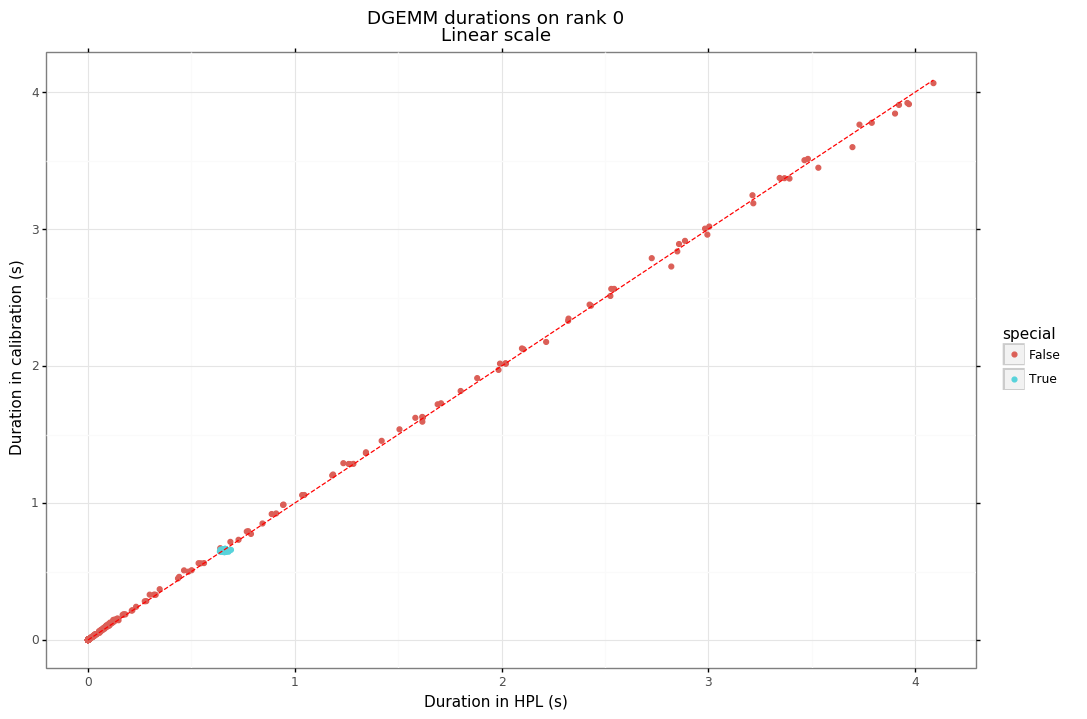

<ggplot: (-9223363286272924458)>


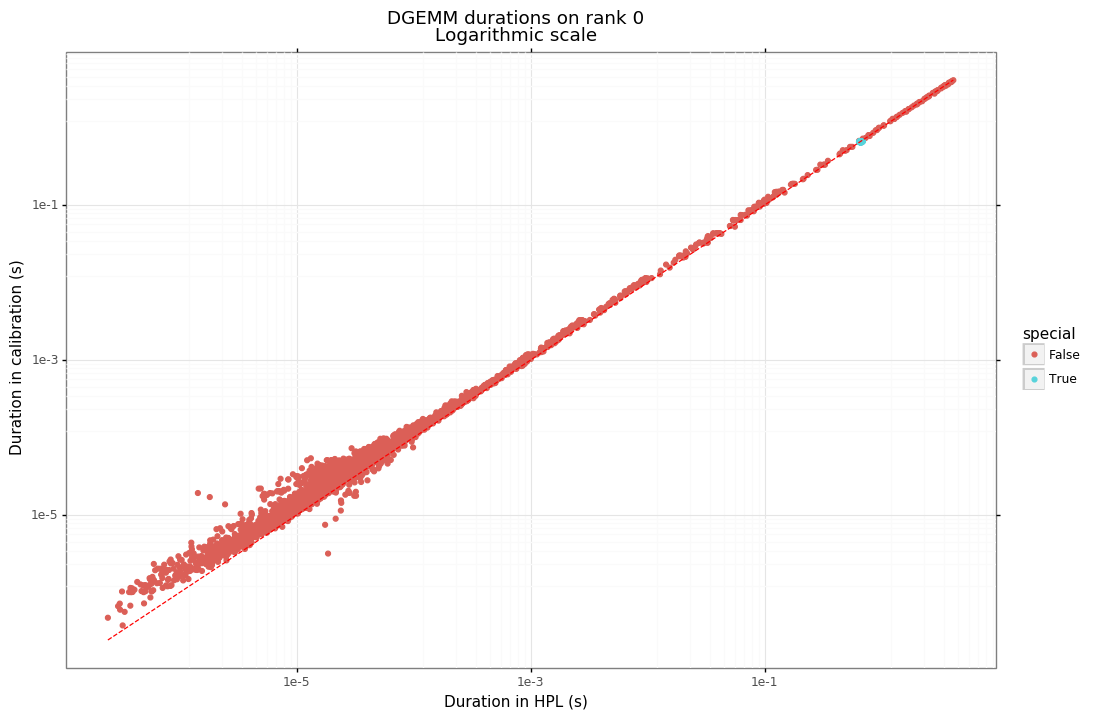

<ggplot: (-9223363286277407004)>


In [7]:
plot = ggplot(traces, aes(x='duration', y='duration_calibration', color='special')) + theme_bw() + geom_point() + geom_line(aes(x='duration', y='duration'), color='red', linetype='dashed')
plot = plot + xlab('Duration in HPL (s)') + ylab('Duration in calibration (s)')
title = 'DGEMM durations on rank 0\n'
print(plot + ggtitle(title + 'Linear scale'))
print(plot + scale_x_log10() + scale_y_log10() + ggtitle(title + 'Logarithmic scale'))

In [8]:
traces['gflops_hpl'] = 2*traces.mnk / traces['duration'] * 1e-9
traces['gflops_calibration'] = 2*traces.mnk / traces['duration_calibration'] * 1e-9

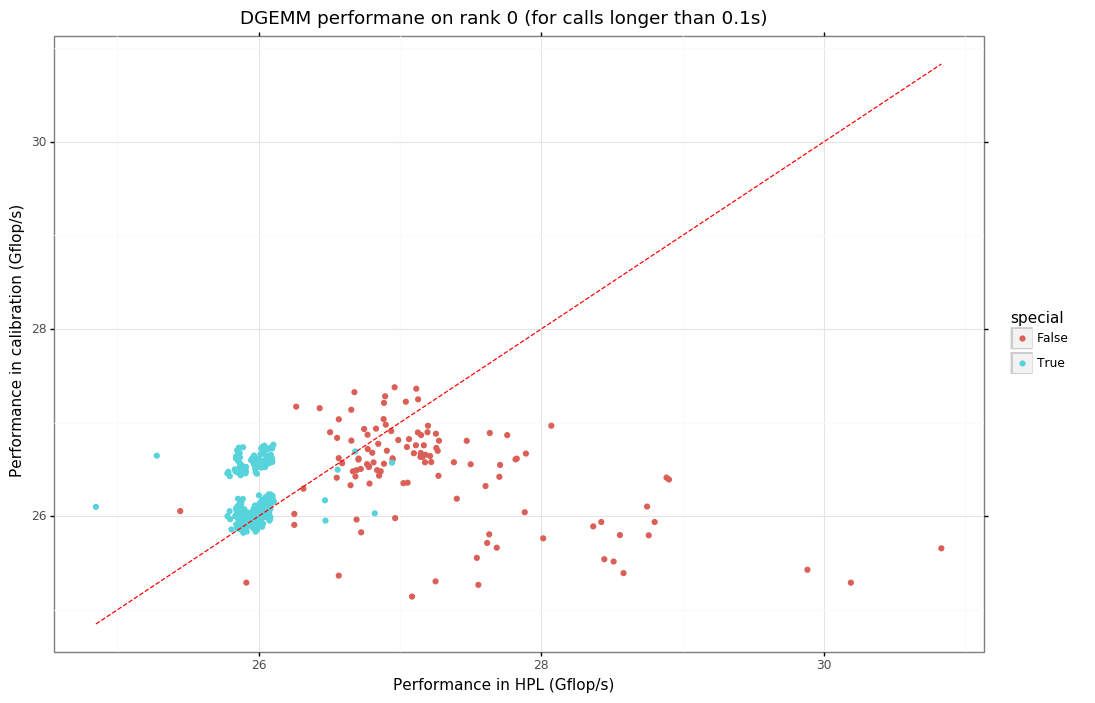

<ggplot: (8750577374272)>

In [9]:
plot = ggplot(traces[traces.duration > 0.1], aes(x='gflops_hpl', y='gflops_calibration', color='special')) + theme_bw() + geom_point() + geom_line(aes(x='gflops_hpl', y='gflops_hpl'), color='red', linetype='dashed')
plot = plot + xlab('Performance in HPL (Gflop/s)') + ylab('Performance in calibration (Gflop/s)')
plot + ggtitle('DGEMM performane on rank 0 (for calls longer than 0.1s)')

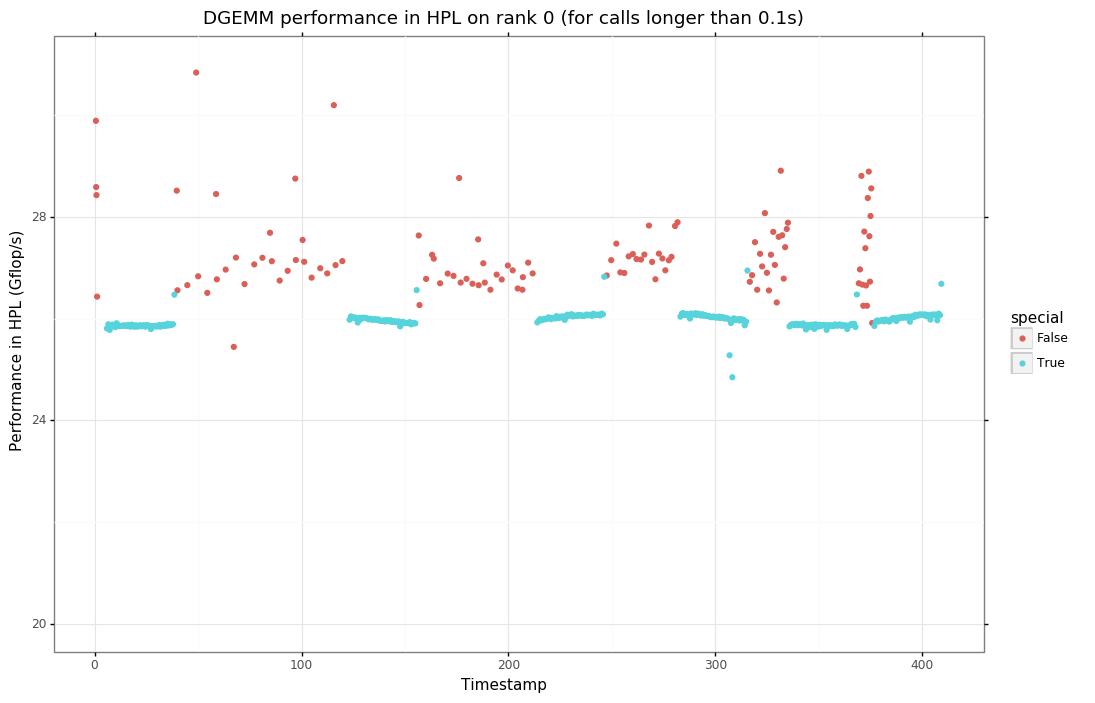

<ggplot: (8750581824036)>

In [10]:
plot = ggplot(traces[traces.duration > 0.1], aes(x='start', y='gflops_hpl', color='special')) + geom_point() + theme_bw()
plot = plot + xlab('Timestamp') + ylab('Performance in HPL (Gflop/s)') + ggtitle('DGEMM performance in HPL on rank 0 (for calls longer than 0.1s)')
plot = plot + expand_limits(y=(20, 31))
plot

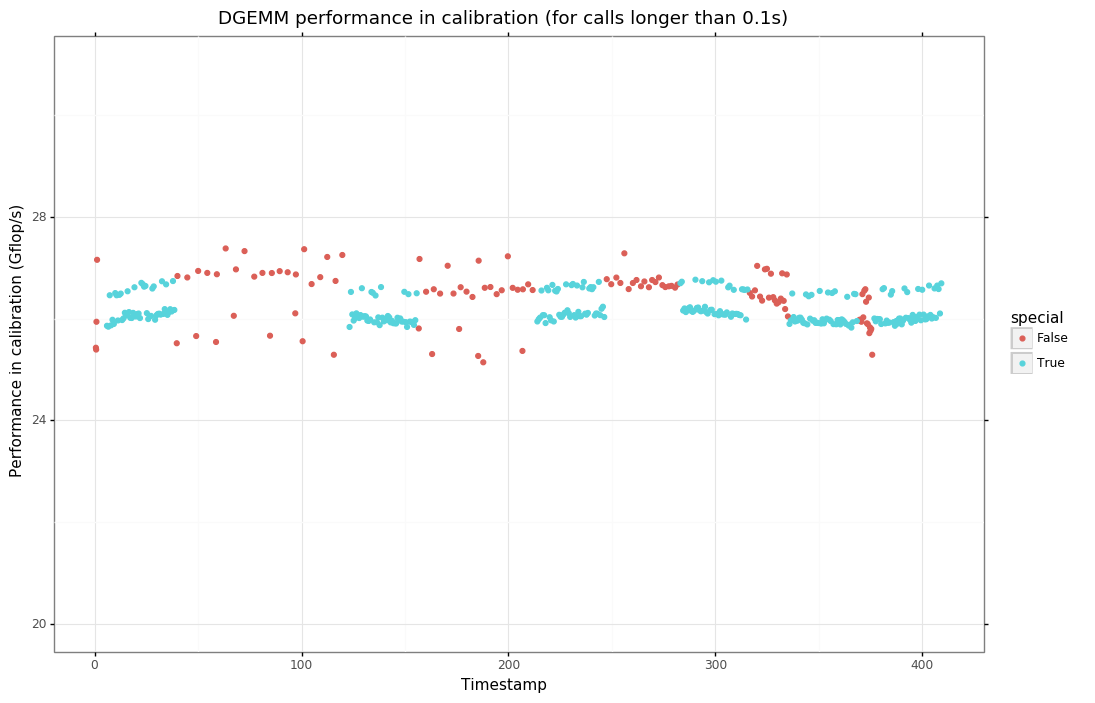

<ggplot: (-9223363286277939831)>

In [11]:
plot = ggplot(traces[traces.duration > 0.1], aes(x='start', y='gflops_calibration', color='special')) + geom_point() + theme_bw()
plot = plot + xlab('Timestamp') + ylab('Performance in calibration (Gflop/s)') + ggtitle('DGEMM performance in calibration (for calls longer than 0.1s)')
plot = plot + expand_limits(y=(20, 31))
plot

In [12]:
summary = traces[['duration', 'duration_calibration', 'mnk']].sum()
summary['gflops'] = 2*summary['mnk'] / summary['duration'] * 1e-9
summary['gflops_calibration'] = 2*summary['mnk'] / summary['duration_calibration'] * 1e-9
summary['error'] = (summary['duration_calibration'] - summary['duration']) / summary['duration']
summary

duration                3.656230e+02
duration_calibration    3.657204e+02
mnk                     4.827587e+12
gflops                  2.640746e+01
gflops_calibration      2.640042e+01
error                   2.665130e-04
dtype: float64

## Monitoring

In [13]:
def get_monitoring(archive_name, csv_name, tag, min_start=None, max_stop=None):
    df = read_csv(archive_name, csv_name)
    for col in ['start', 'stop']:
        df[col] = pandas.to_datetime(df[col])
    first = df['start'].min()
    df['start'] -= first
    df['stop'] -= first
    df['tag'] = tag
    if min_start is not None:
        old_len = len(df)
        df = df[df['start'] >= pandas.to_timedelta(min_start, unit='s')]
        print('Tag %s: removed %d entries that happened before time %.2f s' % (tag, old_len-len(df), min_start))
    if max_stop is not None:
        old_len = len(df)
        df = df[df['stop'] <= pandas.to_timedelta(max_stop, unit='s')]
        print('Tag %s: removed %d entries that happened after time %.2f s' % (tag, old_len-len(df), max_stop))
    if min_start is not None:
        first = df['start'].min()
        df['start'] -= first
        df['stop'] -= first
    return df

In [14]:
temperature = pandas.concat([
    get_monitoring(archive, 'monitoring_temp.csv', tag='HPL'),
    get_monitoring(calibration_archive, 'monitoring_temp.csv', tag='calibration', min_start=traces_calibration.start.min(), max_stop=traces_calibration.end.max())
])
temperature.head()

Tag calibration: removed 730 entries that happened before time 365.52 s
Tag calibration: removed 824 entries that happened after time 731.27 s


,hostname,start,stop,sensor_id,temperature,jobid,tag
0,dahu-23.grenoble.grid5000.fr,00:00:00,00:00:00.000114,0,76.0,1889002,HPL
1,dahu-23.grenoble.grid5000.fr,00:00:00,00:00:00.000114,1,59.0,1889002,HPL
2,dahu-23.grenoble.grid5000.fr,00:00:01.002478,00:00:01.002842,0,79.0,1889002,HPL
3,dahu-23.grenoble.grid5000.fr,00:00:01.002478,00:00:01.002842,1,64.0,1889002,HPL
4,dahu-23.grenoble.grid5000.fr,00:00:02.005676,00:00:02.005890,0,78.0,1889002,HPL


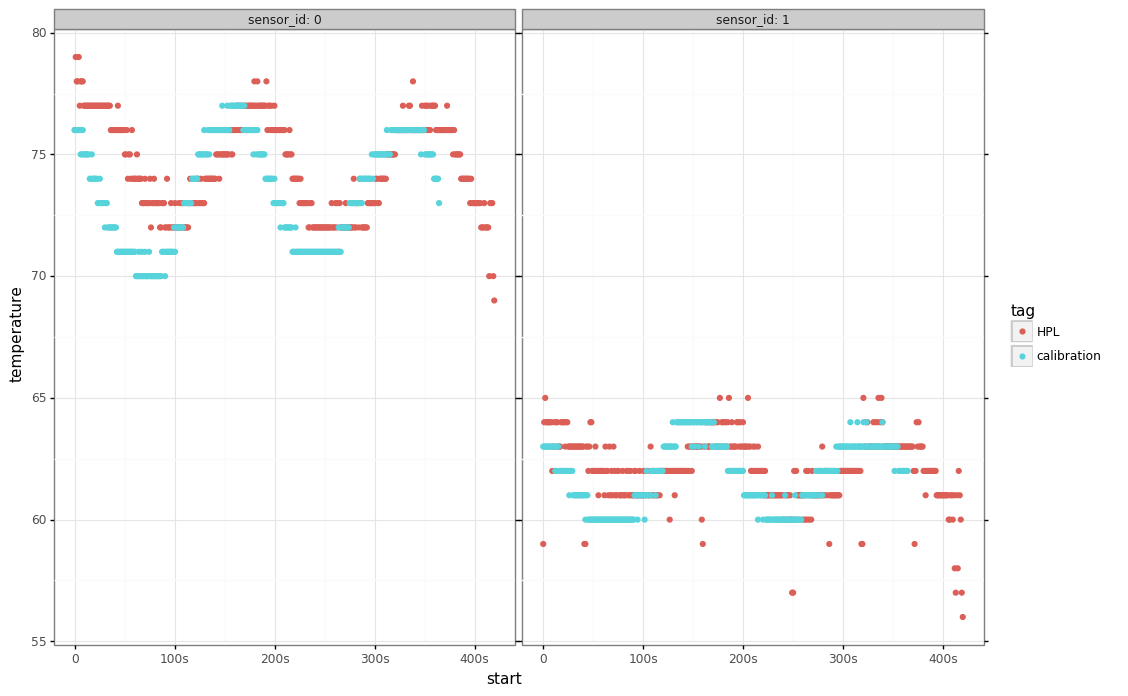

<ggplot: (8750572968214)>

In [15]:
ggplot(temperature, aes(x='start', y='temperature', color='tag')) + geom_point() + theme_bw() +  facet_wrap('sensor_id', labeller='label_both')

In [16]:
frequency = pandas.concat([
    get_monitoring(archive, 'monitoring_freq.csv', tag='HPL'),
    get_monitoring(calibration_archive, 'monitoring_freq.csv', tag='calibration', min_start=traces_calibration.start.min(), max_stop=traces_calibration.end.max())
])
frequency['frequency'] *= 1e-9
frequency.head()

Tag calibration: removed 23360 entries that happened before time 365.52 s
Tag calibration: removed 26368 entries that happened after time 731.27 s


,hostname,start,stop,core_id,frequency,jobid,tag
0,dahu-23.grenoble.grid5000.fr,0 days,00:00:00.001615,0,2.799957,1889002,HPL
1,dahu-23.grenoble.grid5000.fr,0 days,00:00:00.001615,1,2.799957,1889002,HPL
2,dahu-23.grenoble.grid5000.fr,0 days,00:00:00.001615,2,2.799957,1889002,HPL
3,dahu-23.grenoble.grid5000.fr,0 days,00:00:00.001615,3,2.799957,1889002,HPL
4,dahu-23.grenoble.grid5000.fr,0 days,00:00:00.001615,4,2.799957,1889002,HPL


In [17]:
frequency['cpu_id'] = frequency['core_id'] % 2
frequency = frequency[frequency['core_id'] < 32]  # removing the hyperthread cores

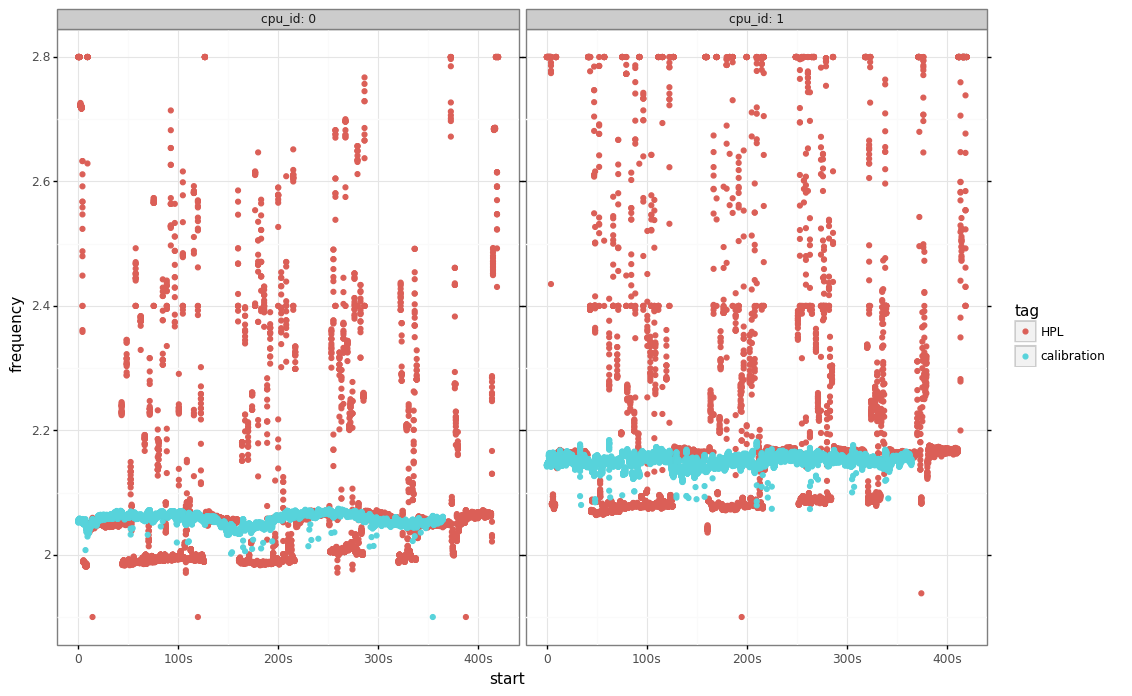

<ggplot: (8750572848455)>

In [18]:
ggplot(frequency, aes(x='start', y='frequency', color='tag')) + geom_point() + theme_bw() +  facet_wrap('cpu_id', labeller='label_both')

Second special dgemm phase: 123.22s - 156.29s  (HPL)


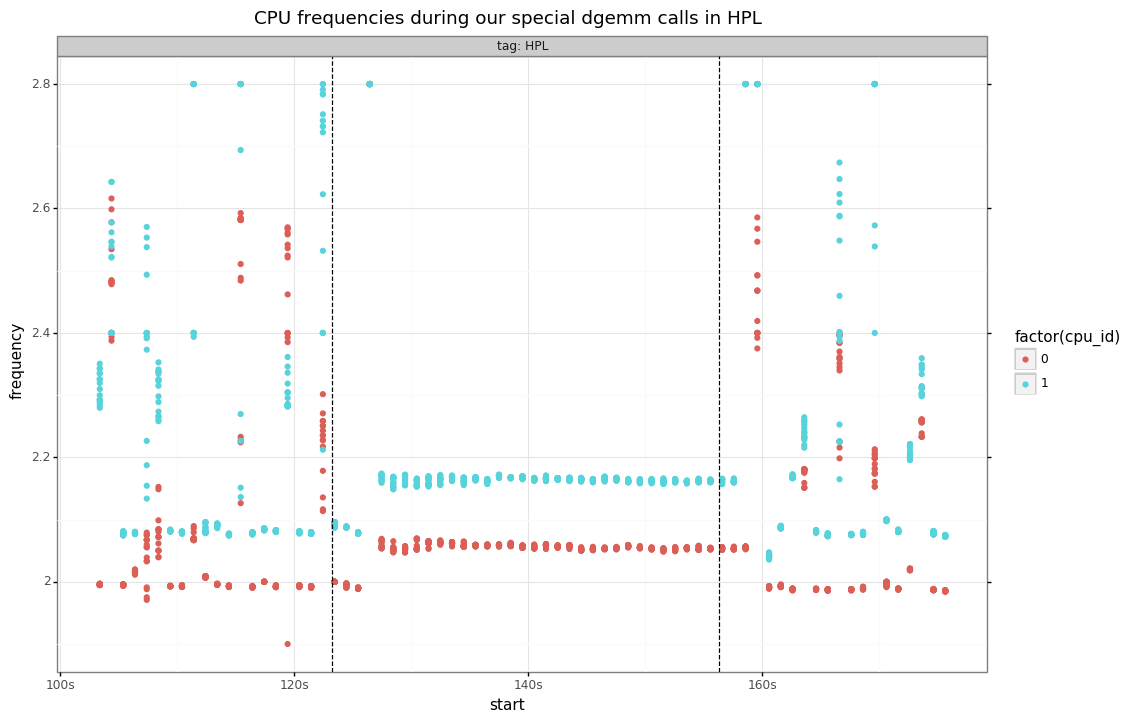

<ggplot: (-9223363286282263608)>
Second special dgemm phase: 107.41s - 140.36s  (calibration)


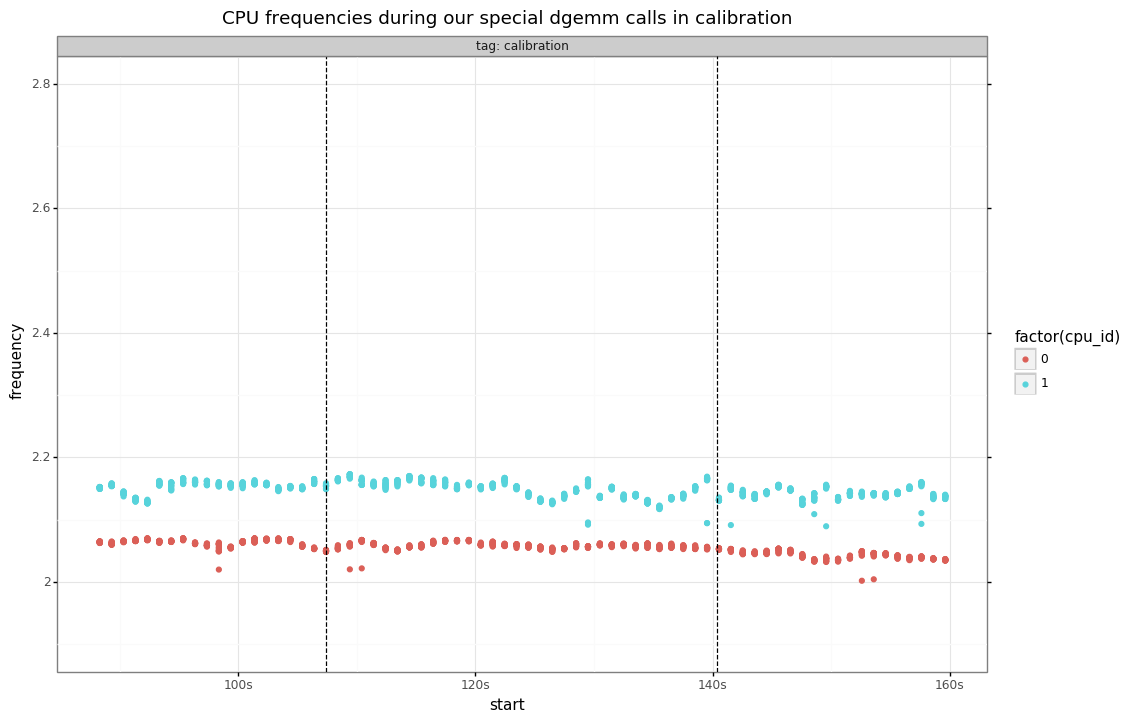

<ggplot: (-9223363286281840324)>


In [19]:
for tag in ['HPL', 'calibration']:
    special_dgemm = traces[traces.special]
    if tag == 'HPL':
        start = special_dgemm[special_dgemm.start > 100].start.min()
        stop = special_dgemm[special_dgemm.end < 180].end.max()
    elif tag == 'calibration':
        first = traces_calibration['start'].min()
        start = special_dgemm[special_dgemm.start_calibration > 100 + first].start_calibration.min() - first
        stop = special_dgemm[special_dgemm.end_calibration < 180 + first].end_calibration.max() - first
    print('Second special dgemm phase: %.2fs - %.2fs  (%s)' % (start, stop, tag))
    start_window = pandas.to_timedelta(start-20, unit='s')
    stop_window = pandas.to_timedelta(stop+20, unit='s')
    start = pandas.to_timedelta(start, unit='s')
    stop = pandas.to_timedelta(stop, unit='s')
    plot = ggplot(frequency[(frequency.start >= start_window) & (frequency.start <= stop_window) & (frequency.tag == tag)], aes(x='start', y='frequency', color='factor(cpu_id)')) 
    plot = plot + geom_point() + theme_bw() +  facet_wrap('tag', labeller='label_both')
    plot = plot + geom_vline(xintercept=start, linetype='dashed') + geom_vline(xintercept=stop, linetype='dashed')
    plot = plot + ggtitle('CPU frequencies during our special dgemm calls in %s' % tag) + expand_limits(y=(1.9, 2.8))
    print(plot)

## Trace of the commands

In [20]:
def print_commands(archive):
    print(zipfile.ZipFile(archive).read('commands.log').decode())

print_commands(archive)

[2019-10-16 16:41:42,511][INFO] Starting a new job, args = {'command': 'run', 'username': 'tocornebize', 'deploy': 'debian9-x64-base', 'jobid': ('grenoble', 1889002), 'expfile': [ExpFile(exp_hpl.csv)], 'installfile': InstallFile(install_hpl.yaml), 'batch': False}
[2019-10-16 16:41:42,514][DEBUG] [frontend | /home/tocornebize] oarstat -fJ -j 1889002
[2019-10-16 16:41:43,029][INFO] HPL(1889002) with 1 nodes
[2019-10-16 16:41:43,029][INFO] Setting up
[2019-10-16 16:41:43,029][DEBUG] [frontend | /home/tocornebize] kadeploy3 -k -f /var/lib/oar/1889002 -e debian9-x64-base --env-version 2019040916
[2019-10-16 16:46:16,949][DEBUG] [allnodes | /tmp] echo "hello world"
[2019-10-16 16:46:17,145][DEBUG] [allnodes | /tmp] cat /sys/class/thermal/thermal_zone*/temp
[2019-10-16 16:46:17,203][DEBUG] [allnodes | /tmp] rm -rf /tmp/*
[2019-10-16 16:46:17,241][DEBUG] [director | /tmp] echo UEsFBgAAAAAAAAAAAAAAAAAAAAAAAA== | base64 -d > grenoble_2019-10-16_1889002.zip
[2019-10-16 16:46:17,289][DEBUG] [direc

In [21]:
print_commands(calibration_archive)

[2019-10-17 10:33:46,748][INFO] Starting a new job, args = {'command': 'run', 'username': 'tocornebize', 'deploy': 'debian9-x64-base', 'jobid': ('grenoble', 1889169), 'expfile': [ExpFile(exp_hpl.csv)], 'installfile': InstallFile(install_hpl.yaml), 'batch': False}
[2019-10-17 10:33:46,756][DEBUG] [frontend | /home/tocornebize] oarstat -fJ -j 1889169
[2019-10-17 10:33:47,189][INFO] BLASCalibration(1889169) with 1 nodes
[2019-10-17 10:33:47,189][INFO] Setting up
[2019-10-17 10:33:47,189][DEBUG] [frontend | /home/tocornebize] kadeploy3 -k -f /var/lib/oar/1889169 -e debian9-x64-base --env-version 2019040916
[2019-10-17 10:38:22,145][DEBUG] [allnodes | /tmp] echo "hello world"
[2019-10-17 10:38:22,386][DEBUG] [allnodes | /tmp] cat /sys/class/thermal/thermal_zone*/temp
[2019-10-17 10:38:22,420][DEBUG] [allnodes | /tmp] rm -rf /tmp/*
[2019-10-17 10:38:22,468][DEBUG] [director | /tmp] echo UEsFBgAAAAAAAAAAAAAAAAAAAAAAAA== | base64 -d > grenoble_2019-10-17_1889169.zip
[2019-10-17 10:38:22,526][D